# Configurações iniciais

In [1]:
%tensorflow_version 1.x

# Install
!pip install innvestigate -q
!pip uninstall scipy -yq
!pip install scipy==1.1.0 -q
!pip install git+https://github.com/raghakot/keras-vis -U -q

# Imports
import warnings
import numpy as np
from multiprocessing import cpu_count
import matplotlib
import matplotlib.pyplot as plt
import keras
import innvestigate
import scipy
import vis
from vis.visualization import visualize_activation
from vis.utils import utils

# Config
warnings.simplefilter('ignore')
np.random.seed(0)
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
nproc = cpu_count()

TensorFlow 1.x selected.
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


Using TensorFlow backend.


# Base de dados (MNIST)

In [2]:
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

# Modelo classificador (rede neural convolucional)

In [3]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
                              activation='relu',input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))

model.get_config()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


{'layers': [{'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'batch_input_shape': (None, 28, 28, 1),
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 32,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (3, 3),
    'name': 'conv2d_1',
    'padding': 'valid',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True}},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'ch

O modelo foi treinado e nas execuções seguintes o modelo salvo foi usado, por isso o código a seguir está comentado

In [4]:
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(x_train, y_train, epochs=5)
# evaluation = model.evaluate(x_test, y_test)
# model.save('mnist_model.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





60000/60000 [==============================] - 172s 3ms/step - loss: 0.1844 - acc: 0.9440
Epoch 2/5
60000/60000 [==============================] - 176s 3ms/step - loss: 0.0784 - acc: 0.9766
Epoch 3/5
60000/60000 [==============================] - 171s 3ms/step - loss: 0.0603 - acc: 0.9815
Epoch 4/5
60000/60000 [==============================] - 171s 3ms/step - loss: 0.0508 - acc: 0.9848
Epoch 5/5
10000/10000 [==============================] - 7s 672us/step


# Innvestigate

## Examplo dado no enunciado (LRP-Epsilon)

In [5]:
model = keras.models.load_model('mnist_model.h5')
model_wo_sm = innvestigate.utils.keras.graph.model_wo_softmax(model)

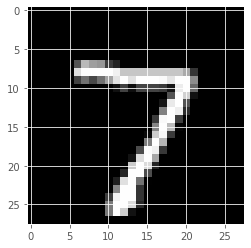

In [6]:
imagem = x_test[0:1]
plt.imshow(imagem.squeeze(), cmap='gray', interpolation='nearest')

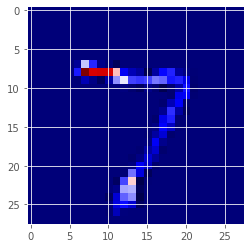

In [7]:
analyzer = innvestigate.analyzer.LRPEpsilon(model=model_wo_sm,
 epsilon=1)
analysis = analyzer.analyze(imagem)
plt.imshow(analysis.squeeze(), cmap='seismic',
           interpolation='nearest')

## Exercício (vários métodos de análise)

In [8]:
input_range = [0, 1]
noise_scale = 0.1
ri = 0

# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       'gray',      "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},   'gray',        "Gradient"),
    ("smoothgrad",            {"noise_scale": noise_scale,
                               "postprocess": "square"},'gray',        "SmoothGrad"),

    # Interaction
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, 'seismic',        "DeepTaylor"),
    ("lrp.alpha_beta",         {"alpha": 2, "beta": 1}, 'seismic',          "LRP-AlphaBeta"),  
    ("lrp.epsilon",           {"epsilon": 1},           'seismic',        "LRP-Epsilon"),    
    ("lrp.z",                 {},                       'seismic',        "LRP-Z"),

]

In [27]:
# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_sm,      # model without softmax output
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(x_train, batch_size=256, verbose=1)
    analyzers.append(analyzer)

In [29]:
num_classes = len(np.unique(y_train))
label_to_class_name = [str(i) for i in range(num_classes)]

class1 = np.array([(e, f) for i, (e, f) in enumerate(zip(x_test, y_test)) if f == 1])
class2 = np.array([(e, f) for i, (e, f) in enumerate(zip(x_test, y_test)) if f == 2])
class3 = np.array([(e, f) for i, (e, f) in enumerate(zip(x_test, y_test)) if f == 3])

idx1 = [np.random.randint(len(class1)) for _ in range(2)]
idx2 = [np.random.randint(len(class2)) for _ in range(2)]
idx3 = [np.random.randint(len(class3)) for _ in range(2)]

test_images = []
test_images += list(class1[idx1])
test_images += list(class2[idx2])
test_images += list(class3[idx3])

print(np.array(test_images)[0].shape)

analysis = np.zeros([len(test_images), len(analyzers), 28, 28, 1])
text = []

for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_sm.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        # Store the analysis.
        analysis[i, aidx] = a

(2,)


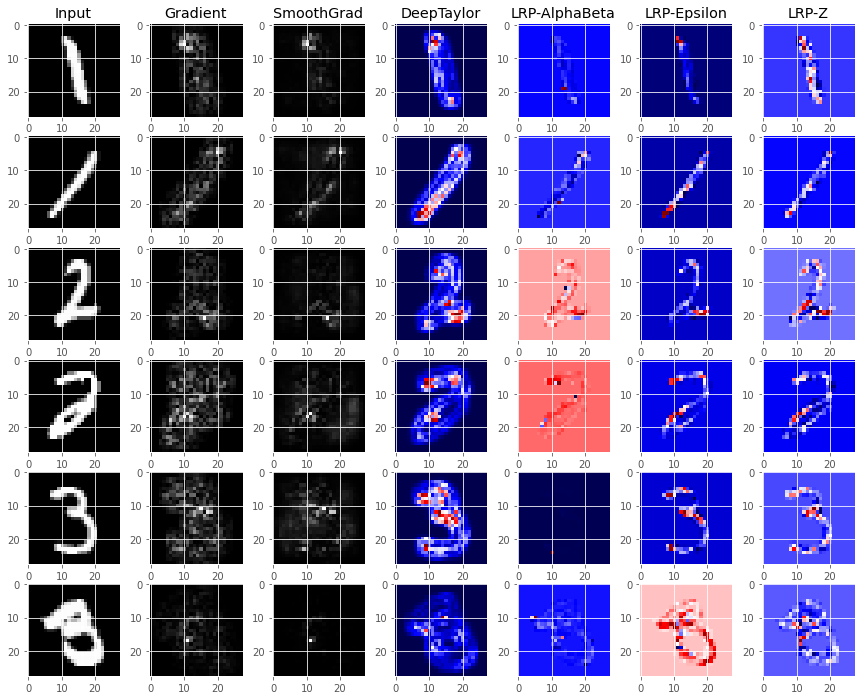

In [38]:
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
plt.figure(figsize=(15,12))
for i in range(analysis.shape[0]):
    for j in range(analysis.shape[1]):
        ax = plt.subplot(analysis.shape[0], analysis.shape[1], i*(analysis.shape[1])+j+1)
        ax.imshow(analysis[i,j].squeeze(), cmap=methods[j][2], interpolation="nearest")
        if i==0:
            ax.set_title(col_labels[j])
plt.show()

## Análise

Para os exemplos analisados podemos perceber que as estratégias DeepTaylor e LRP (sobretudo LRP-epsilon e LRP-z) são uma forma muito potente para entender como cada parte da imagem contribui para sua classificação. O gradiente nos da alguma ideia disso, mas com o LRP é possível identificar claramente quais pontos foram mais relevantes para sua classificação.

# Keras-vis

## Examplo dado

In [39]:
model = keras.models.load_model('mnist_model.h5')
layer_idx = utils.find_layer_idx(model, 'dense_2')
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

Iteration: 1, named_losses: [('ActivationMax Loss', 0.95365083), ('TV(2.0) Loss', 0.009343703)], overall loss: 0.9629945158958435
Iteration: 2, named_losses: [('ActivationMax Loss', -79.63988), ('TV(2.0) Loss', 54.366787)], overall loss: -25.273090362548828
Iteration: 3, named_losses: [('ActivationMax Loss', -408.11038), ('TV(2.0) Loss', 70.48827)], overall loss: -337.6221008300781
Iteration: 4, named_losses: [('ActivationMax Loss', -715.0461), ('TV(2.0) Loss', 83.1236)], overall loss: -631.9224853515625
Iteration: 5, named_losses: [('ActivationMax Loss', -987.19824), ('TV(2.0) Loss', 108.10808)], overall loss: -879.0901489257812
Iteration: 6, named_losses: [('ActivationMax Loss', -1220.8551), ('TV(2.0) Loss', 139.07086)], overall loss: -1081.7841796875
Iteration: 7, named_losses: [('ActivationMax Loss', -1423.8668), ('TV(2.0) Loss', 173.54063)], overall loss: -1250.326171875
Iteration: 8, named_losses: [('ActivationMax Loss', -1630.276), ('TV(2.0) Loss', 211.41428)], overall loss: -14

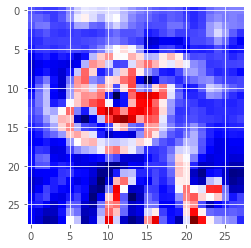

In [13]:
filter_idx = 9
img = visualize_activation(model, layer_idx,
                           filter_indices=filter_idx, input_range=(0., 1.), verbose=True,
                           max_iter=1000, tv_weight=1., lp_norm_weight=0.)
plt.imshow(img.squeeze(), cmap='seismic', interpolation='nearest')

## Exercício

Foram feitos 4 experimentos variando-se tv_weight e lp_norm. O aumento de tv_weight suavisa as bordas do analisador e o aumento de lp_norm tende a priorizar valores próximos de zero, o que também pode suavisar as bordas, mas por outro lado diminui a distinção entre as regiões de contribuição.

### Experiment 1: tv_weight = 4; lp_norm_weight=1e-3


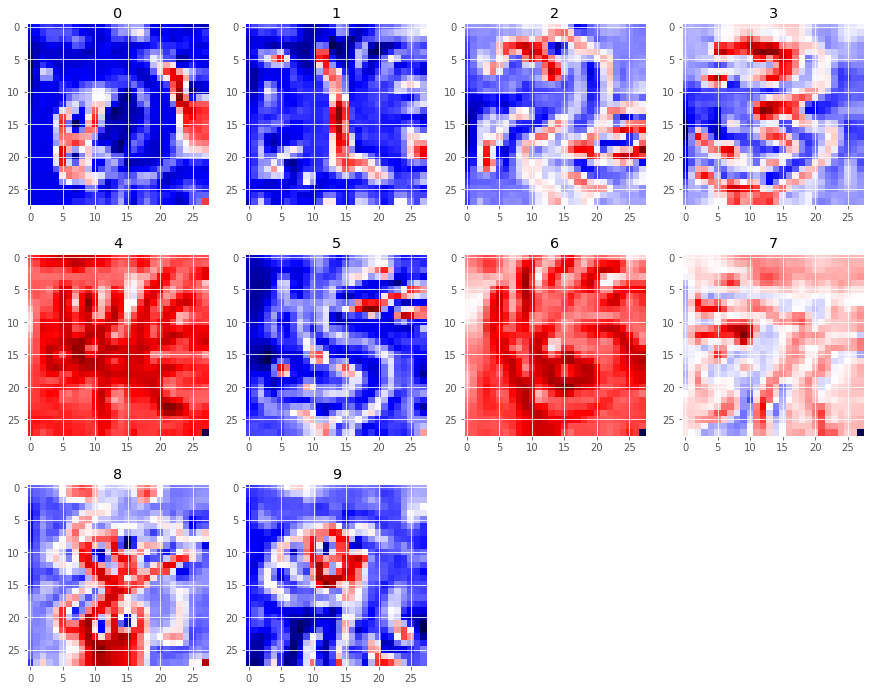

In [65]:
plt.figure(figsize=(15,12))
for i, e in enumerate(label_to_class_name):
    img = visualize_activation(model, layer_idx,
                           filter_indices=i, input_range=(0., 1.), verbose=False,
                           max_iter=1000, tv_weight=4, lp_norm_weight=1e-3)
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img.squeeze(), cmap='seismic', interpolation='nearest')
    ax.set_title(e)
plt.show()

### Experiment 2: tv_weight = 1 ; lp_norm_weight=1e-3


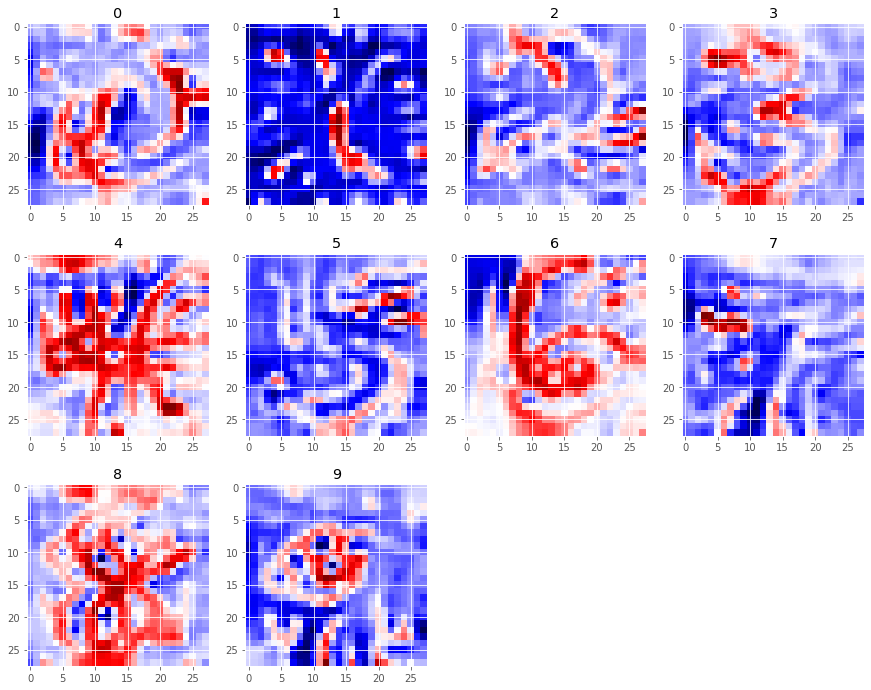

In [67]:
plt.figure(figsize=(15,12))
for i, e in enumerate(label_to_class_name):
    img = visualize_activation(model, layer_idx,
                           filter_indices=i, input_range=(0., 1.), verbose=False,
                           max_iter=1000, tv_weight=1, lp_norm_weight=1e-3)
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img.squeeze(), cmap='seismic', interpolation='nearest')
    ax.set_title(e)
plt.show()

### Experiment 3: tv_weight = 1; lp_norm_weight=1e-2


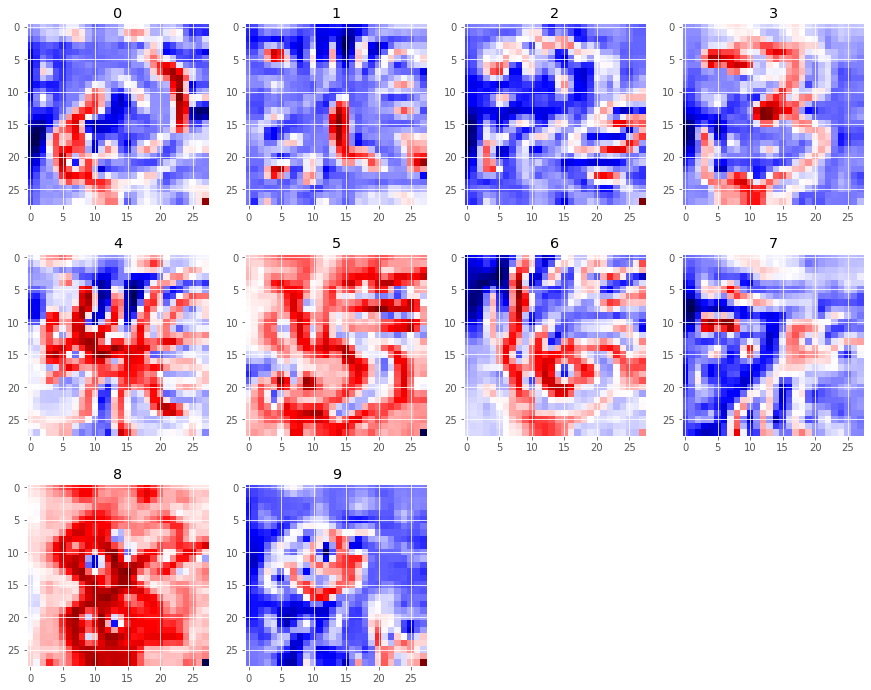

In [68]:
plt.figure(figsize=(15,12))
for i, e in enumerate(label_to_class_name):
    img = visualize_activation(model, layer_idx,
                           filter_indices=i, input_range=(0., 1.), verbose=False,
                           max_iter=1000, tv_weight=1, lp_norm_weight=1e-2)
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img.squeeze(), cmap='seismic', interpolation='nearest')
    ax.set_title(e)
plt.show()

### Experiment 4: tv_weight = 1; lp_norm_weight=0


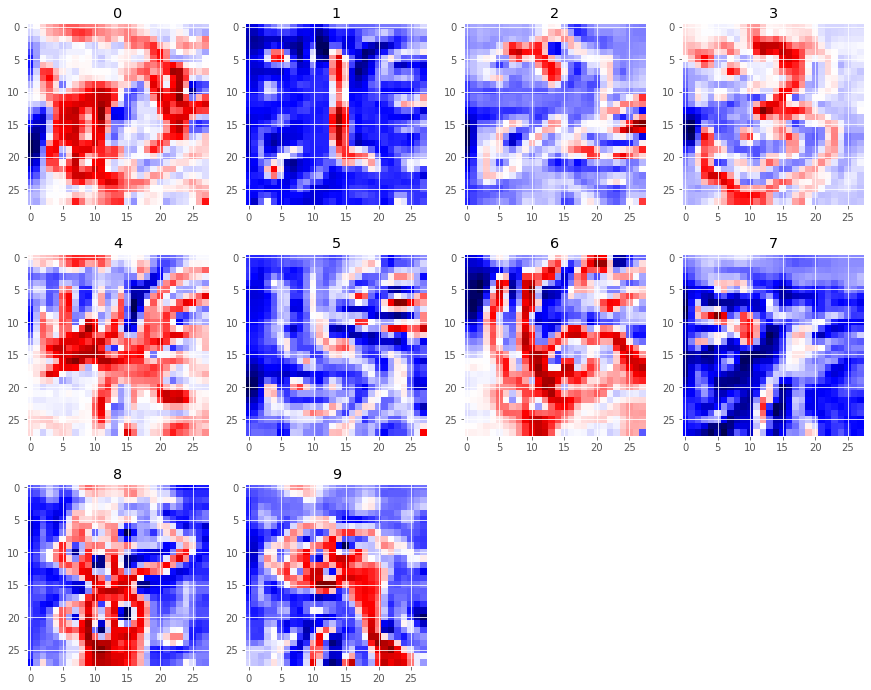

In [69]:
plt.figure(figsize=(15,12))
for i, e in enumerate(label_to_class_name):
    img = visualize_activation(model, layer_idx,
                           filter_indices=i, input_range=(0., 1.), verbose=False,
                           max_iter=1000, tv_weight=1, lp_norm_weight=0)
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img.squeeze(), cmap='seismic', interpolation='nearest')
    ax.set_title(e)
plt.show()

## Análise

O método keras-vis nos permite fazer uma análise inversa do que o método LRP. Com ele, podemos ver qual seria a entrada esperada que conseguiria uma classificação máxima. Podemos ver ainda pelos experimentos que a maioria dos classificadores resultaram em uma imagem que parece ser vários digitos da classe sobrescritos. Alguns dígitos apresentam mapas menos parecidos com dígitos individuais (0, 4, 7, 9), mas outros são bastante parecidos do que os próprios dígitos de entrada (1, 2, 3, 5, 6, 8). Novamente, este é um método bastante potente para interpretabilidade de redes profundas.